# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [1]:
%tensorflow_version 2.x
import tensorflow as tf 
print (tf.__version__)

TensorFlow 2.x selected.
2.1.0


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Change directory

In [0]:
os.chdir('/content/drive/My Drive/AIML_Projects/Sequence Models in NLP/Internal lab/')

In [0]:
project_path = "/content/drive/My Drive/AIML_Projects/Sequence Models in NLP/Internal lab/"

### Load the training data from train.csv file

In [0]:
train = pd.read_csv('train_labels.csv')

In [8]:
train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


### Print the shape of the train dataset

In [11]:
print ('Shape of train is -', train.shape)

Shape of train is - (173, 8)


### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [0]:
IMAGE_SIZE = 128

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [0]:
# path, width, height, x0,y0,x1,y1
import csv
with open('/content/drive/My Drive/AIML_Projects/Sequence Models in NLP/Internal lab/train_labels.csv', 'r') as csvfile:
    paths = []
    coords = np.zeros((sum(1 for line in csvfile), 4))
    reader = csv.reader(csvfile, delimiter=',')
    csvfile.seek(0)
    for col, row in enumerate(reader):
        if col == 0:
            pass
        else:
            path, width, height,_, x0, y0, x1, y1 = row  
            coords[col, 0] = int(x0) * IMAGE_SIZE / int(width)                  # Normalize bounding box by image size
            coords[col, 1] = int(y0) * IMAGE_SIZE / int(height)                 # Normalize bounding box by image size
            coords[col, 2] = (int(x1) - int(x0)) * IMAGE_SIZE / int(width)      # Normalize bounding box by image size
            coords[col, 3] = (int(y1) - int(y0)) * IMAGE_SIZE / int(height)
            paths.append(path)

In [0]:
coords = coords[1:]

In [23]:
len(coords)

173

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [25]:
!pip install rarfile

     |████████████████████████████████| 122kB 2.8MB/s 
  Created wheel for rarfile: filename=rarfile-3.1-cp36-none-any.whl size=24908 sha256=f4e67ab4f5ec270422267f2cf8d2584c116a03d1d8e2fd8a484acbf1c2d31757
  Stored in directory: /root/.cache/pip/wheels/23/3c/c8/0215b6a5079492eff3be3f545ae0b0c4a66734c35c9e444eac
Successfully built rarfile


In [0]:
train_images = '/content/drive/My Drive/AIML_Projects/Sequence Models in NLP/Internal lab/images/'

In [0]:
from rarfile import RarFile

In [0]:
with RarFile('/content/drive/My Drive/AIML_Projects/Sequence Models in NLP/Internal lab/images_racoon.rar','r') as z:
    z.extractall()

In [0]:
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input

In [0]:
# from tqdm import tqdm
import cv2
from PIL import Image
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
for i, f in enumerate(paths):
    img = Image.open(train_images+f) # Read image
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
    img = img.convert('RGB')
    batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))

In [37]:
batch_images.shape

(173, 128, 128, 3)

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [0]:
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.layers import Conv2D, Reshape
from tensorflow.keras.utils import Sequence
from tensorflow.keras.backend import epsilon

In [0]:
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=1) # Load pre-trained mobilenet

In [0]:
# to freeze layers, except the new top layer, of course, which will be added below
for layer in model.layers:
    layer.trainable = False

In [0]:
# Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
x = model.layers[-1].output
x = Conv2D(4, kernel_size=4, name="coords")(x)
# In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
x = Reshape((4,))(x) # These are the 4 predicted coordinates of one BBox

model = Model(inputs=model.input, outputs=x)

### Define a custom loss function IoU which calculates Intersection Over Union

In [0]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_function(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [0]:
gt = coords

In [101]:
model.compile(optimizer='Adam', loss='mse', metrics=[IoU]) # Regression loss is MSE

model.fit(batch_images,gt,
            epochs=30,batch_size = 32,
            verbose=1)

Train on 173 samples
Epoch 1/30
173/173 [==============================] - 5s 29ms/sample - loss: 83.7120 - IoU: 0.7967
Epoch 2/30
173/173 [==============================] - 4s 21ms/sample - loss: 74.1709 - IoU: 0.7924
Epoch 3/30
173/173 [==============================] - 4s 21ms/sample - loss: 63.5188 - IoU: 0.7954
Epoch 4/30
173/173 [==============================] - 4s 21ms/sample - loss: 62.6558 - IoU: 0.8096
Epoch 5/30
173/173 [==============================] - 4s 21ms/sample - loss: 64.5446 - IoU: 0.8186
Epoch 6/30
173/173 [==============================] - 4s 21ms/sample - loss: 59.7797 - IoU: 0.8296
Epoch 7/30
173/173 [==============================] - 4s 21ms/sample - loss: 64.9102 - IoU: 0.8267
Epoch 8/30
173/173 [==============================] - 4s 20ms/sample - loss: 66.2168 - IoU: 0.8172
Epoch 9/30
173/173 [==============================] - 4s 21ms/sample - loss: 62.5894 - IoU: 0.8313
Epoch 10/30
173/173 [==============================] - 4s 21ms/sample - loss: 56.7035 - 

### Pick a test image from the given data

In [0]:
import cv2
test_image = '/content/drive/My Drive/AIML_Projects/Sequence Models in NLP/Internal lab/images/images/raccoon-140.jpg'
test_img = cv2.imread(test_image)

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [0]:
image_height, image_width, _ = test_img.shape
image = cv2.resize(test_img, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
scaled_image = preprocess_input(np.array(image, dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [0]:
region = model.predict(x=np.array([scaled_image]))[0] # Predict the BBox

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

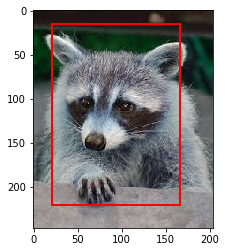

In [105]:
x0 = int(region[0] * image_width / IMAGE_SIZE)                                  # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(test_img)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

# Time Series Prediction using LSTM

### Download Data
Link: https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line

#### Description
Daily minimum temperatures in Melbourne, Australia, 1981-1990

Units: Degrees Celcius

#### Steps before loading
- Rename the column name with temprature values to "Temprature"
- In the last, there is one extra row in the data, remove it by opening the file and save it again.
- There are some values in Temprature column which have a "?" before them, they will give error, remove "?" before them and save the file
- If you don't want to do these steps, just load the data file given by Great Learning.

#### Mount google drive

#### Change your present working directory

### Load your data file

#### Plot data

#### Descibe your dataframe

#### Check for null values

#### Drop null values

#### Get the representation of the distribution of data in the form of histogram

#### Check the maximum and minimum values

### Normalize the data

#### Check the maximum and minimum values of scaled data

#### Look into some of the scaled values

### Split data into Training and Testing

#### Print train and test size

## Create the sequential data
Map the temprature at a particular time t to the temprature at time t+n, where n is any number you define.

For example: to map tempratures of consecutive days, use t+1, i.e. loop_back = 1

#### Define your function to create dataset

#### Use function to get training and test set

#### Transform the prepared train and test input data into the expected structure using numpy.reshape()

## Define Model

### Define sequntial model, add LSTM layer and compile the model

### Summarize your model

### Train the model

## Make Predictions and Evaluate your model

## Plot the results